## Abstract

The post's main focus is to identify deep learning applications for noise generation in one dimension. Through the notebook, we'll implement some basic value noise patterns, using them later as the input for a GAN network. We'll also discuss the GAN architecture and the learning process to acquire the noise function. We make the hypotheses that the GAN's learned function will achieve a more natural result than the plain simple value noise.

## 1D Value Noise

Our first approach is to generate the value noise and some layers to make it more appealing. The idea is to set some random values at regular intervals on the x-axis and then use linear interpolation to join them.

For this procedure, we need a basic piecewise interpolation to render straight lines between the value points. In order to know at what interval we are located in the piecewise interpolation, we use the binary search algorithm (in this case, the sequential, but a recursive one could be enough).

### Fundamental functions

In [ ]:
import random
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

The lerp function is the core element for rendering our noise functions. Then a smoothsetp function makes the linear piecewise inerpolation mare organic and with a curve like shape. Altought it's not full smoothing aproach to the peaky function. This function describes a cubic hermite function.

In [ ]:
def lerp (a: float, b: float, t: float) -> float: return (1 - t) * a + t * b

In [ ]:
def lerp_norm(t: float) -> float: return lerp(0.0, 1.0, t)

In [ ]:
def smoothstep (t : float ) -> float : return t * t * (3 - 2 * t)

The following plot is a simple comparision of these two functions in the range 0 - 1.

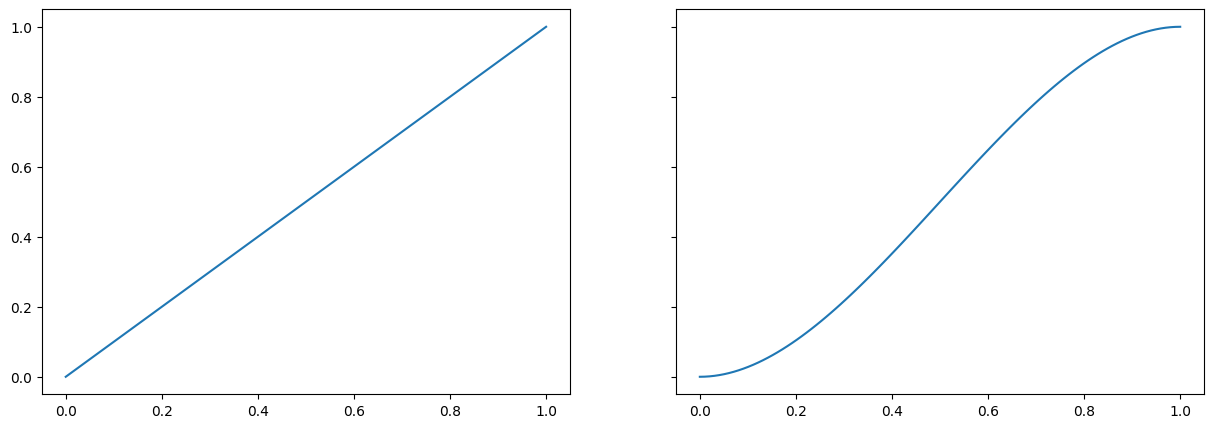

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

x = np.linspace(0.0, 1.0, 100)

ax1.plot(x, lerp_norm(x))
ax2.plot(x, smoothstep(x))

for ax in fig.get_axes():

    ax.label_outer()

For functional purposes the following piecewise definition takes the interpolation function as a parameter. This functional programming approach allows simple variations along the same noise pattern. Later we can decide if we use the lerp or the smoothstep function in its call.

A smoothsetp function makes the linear piecewise inerpolation mare organic with a curve like shape. Altought it's not full smoothing aproach to the peaky function. This function describes a cubic hermite function.

In [ ]:
def binary_search(arr, x):

    low = 0
    high = len(arr) - 1
    mid = 0

    while low <= high:

        mid = (high + low) // 2

        if arr[mid] < x:
            low = mid + 1

        elif arr[mid] > x:
            high = mid - 1

        else:
            return mid

    # return negative when not found
    return -low


In [ ]:
def piecewise_interpolation (lerp1, Xs, Ys, x):

    index = binary_search(Xs,x)

    if (index >= 0):
        return Ys[index]

    index = ~index

    if (index == 0):
        return Ys[0]

    if (index == len(Ys)):
        return Ys[len(Ys)- 1]

    xMin = (int)(x)
    t = x - xMin

    return lerp (Ys[index], Ys[index+1], lerp1(t))


### Value Noise

if we create a 2D noise, we need to assign random values to the vertices of a regular 2D grid (top). For 1D noise, we assign random values at regular intervals on the x-axis (bottom). In both cases, the coordinates of the vertices are integer values. In our example, we only do that for the 10 first numbers, starting from 0 to 9.

In [ ]:
class ValueNoise1D ():

    def __init__(self, func):

        """ init with random values """

        self.steps = 256

        self.func = func

        self.xs = np.arange(0,self.steps,1)

        self.ys = [random.uniform(0.0, 1.0) for _ in range(self.steps)]

    def eval (self, x):

        """ evaluate based on the piecewise interpolation """

        return piecewise_interpolation(self.func, self.xs, self.ys, x % self.steps)

This class encapsulates the disered noise pattern, but we need a new mechanism to draw the function we are building in an elegant manner. Notice how we can specify the period at with the function can replicate, an important parameter for stylized effect we migth want to achive.

Now we generate a bunch of examples so we can see what the noise looks like. The following surfer class is a basic utility for reusable plotting behaviour. By passing the range and the steps we can render the pattern.

In [ ]:
class Surfer():

    def __init__(self, func, x_min= 0, x_max= 10, numSteps=100, color='red'):

        self.func = func
        self.x_min = x_min
        self.x_max = x_max
        self.numSteps = numSteps
        self.color = color

    # what if I want to surf

    def eval (self):

      """ return the data to be plotted """

      t = np.linspace(self.x_min, self.x_max, self.numSteps)

      y_val = [self.func(t_x) for t_x in t]

      return t, y_val

    def surf(self, axis = None):

      """ surfing behaviour, we can take an axis to draw upon it """

      t, y = self.eval()

      if axis is None:

        plt.plot(t, y, color='red')

      else:

        axis.plot(t, y)

In [ ]:
noise_peaky = ValueNoise1D(lerp_norm)
noise_smooth = ValueNoise1D(smoothstep)

s_1 = Surfer(noise_peaky.eval, 0, 10)
s_2 = Surfer(noise_smooth.eval, 10, 25)

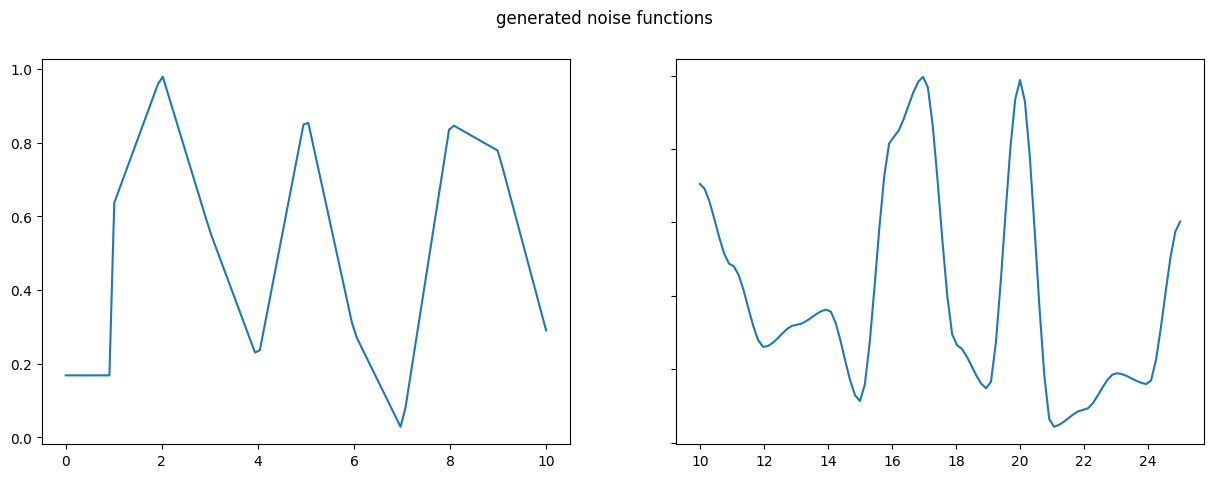

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))

fig.suptitle('generated noise functions')

s_1.surf(ax1)
s_2.surf(ax2)

for ax in fig.get_axes():

    ax.label_outer()

Since these functions are periodic, a simple animation can help us see the pattern repeating. Using FuncAnimation from matplotlib and surfing the noise pattern a few times increasing the t value we get the animated result.

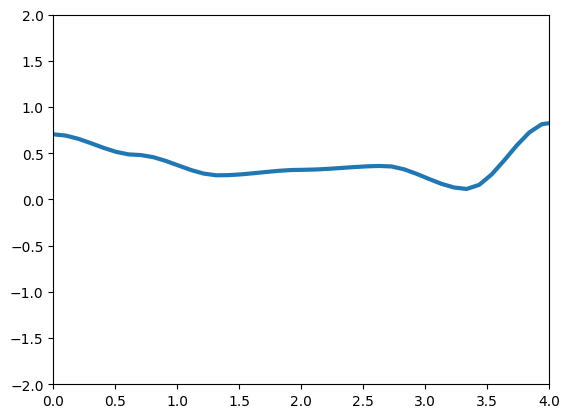

In [ ]:
fig = plt.figure()

axis = plt.axes(xlim =(0, 4), ylim =(-2, 2))

line, = axis.plot([], [], lw = 3)

def init():

    line.set_data([], [])

    return line,

def animate(i):

    x = np.linspace(0, 10, 100)

    s = Surfer(noise_peaky, i+ 0, i+ 10, 100)

    _,y = s_2.eval()

    line.set_data(x, y)

    return line,

anim = FuncAnimation(fig, animate, init_func = init, frames = 200, interval = 20, blit = True)

anim.save('noise_animation.mp4', writer = 'ffmpeg', fps = 30)

In [ ]:
from IPython.display import HTML

from base64 import b64encode

mp4 = open('noise_animation.mp4','rb').read()

data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

### Layered Noise

Based on this noise, we can even create a more refined pattern by adding layers with different parameters. Let's see the effect of different layers of noise putted together in one function with their respected weights.

We could vary the parameters of these various noise layers (or octaves) - for example, change their frequency and amplitude - in a coherent manner. In other words, we can establish a connection between the change in frequency and amplitude from layer to layer.

In [ ]:
class LayeredNoise():

    """ layered noise """

    def __init__(self, noise, numLayers=5):

        self.numLayers = numLayers;

        self.noise = noise

    def eval(self, x):

        amplitude = 1
        frequency = 1
        noiseSum = 0.0

        for i in range(self.numLayers):

            # keep the 1D noise:

            noiseSum += self.noise.eval(x * frequency) * amplitude;
            amplitude *= 0.5
            frequency *= 2

        return noiseSum

In [ ]:
noise_l1 = LayeredNoise(noise_peaky, numLayers = 3)
noise_l2 = LayeredNoise(noise_smooth, numLayers = 3)

s_1 = Surfer(noise_l1.eval, 0, 10, 1000)
s_2 = Surfer(noise_l2.eval, 10, 25, 1000)

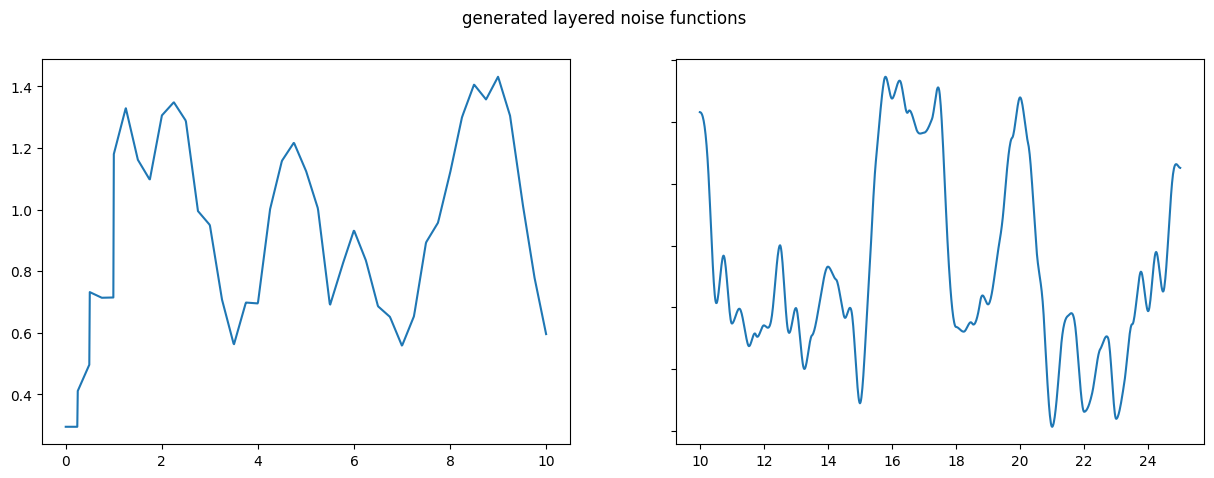

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,5))

fig.suptitle('generated layered noise functions')

s_1.surf(ax1)
s_2.surf(ax2)

for ax in fig.get_axes():

    ax.label_outer()

## GAN learning the noise pattern

Based on the noise we just created we'll make a GAN learn the last function. This Deep Learning mechanism is aimed at generating a more organic pattern than the one created with the classical noise. 

In [ ]:
import tensorflow as tf

In [ ]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
# from keras.models import Sequential
# from keras.layers import Dense
from matplotlib import pyplot

from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


### Generator

In [ ]:
def define_discriminator(n_inputs=2):

	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))

	return model

In [ ]:
model = define_discriminator()

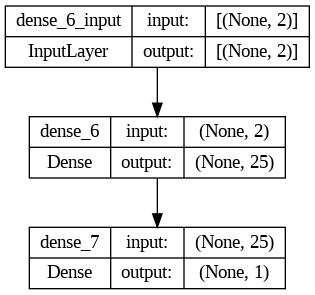

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

### Discriminator

In [ ]:
def define_generator(latent_dim, n_outputs=2):

	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))

	return model

In [ ]:
model = define_generator(5)

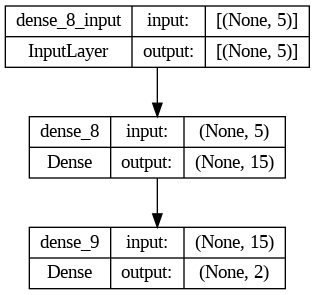

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True)

### GAN training

In [ ]:
dis = define_discriminator()
gen = define_generator(5)

In [ ]:
def sampler(func, n = 1000):

  x_min, x_max = 0, 5

  x = np.random.uniform(x_min, x_max, size=n)

  y = np.array([func(xt) for xt in x])

  return x,y

In [ ]:
def generate_real_samples(sampler, func, n):

  X1, X2 = sampler(func,n)

  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)

  X = hstack((X1, X2))

  y = ones((n, 1))

  return X, y

In [ ]:

def generate_latent_points(latent_dim, n):

  """ generate points in latent space as input for the generator """

  x_input = randn(latent_dim * n)

  x_input = x_input.reshape(n, latent_dim)

  return x_input

def generate_fake_samples(generator, latent_dim, n):

  """ use the generator to generate n fake examples, with class labels """

  x_input = generate_latent_points(latent_dim, n)

  X = generator(x_input)

  y = zeros((n, 1))

  return X, y


In [ ]:
class GAN_1D(tf.keras.Model):

  def __init__(self, generator, discriminator, latent_dim):

    super().__init__()

    self.gen = generator
    self.dis = discriminator
    self.latent_dim = latent_dim

    self.d_optimizer = keras.optimizers.Adam(learning_rate=0.0003)
    self.g_optimizer = keras.optimizers.Adam(learning_rate=0.0004)

    self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)

  @tf.function
  def train_step(self, data):

    self.func = noise_smooth.eval

    n_batch=64
    half_batch = int(n_batch / 2)

    x_real, y_real = generate_real_samples(sampler, self.func, half_batch)
    x_fake, y_fake = generate_fake_samples(self.gen, self.latent_dim, half_batch)

    X = tf.concat([x_real, x_fake], axis=0)
    Y = tf.concat([y_real, y_fake], axis=0)

    # train discriminator

    with tf.GradientTape() as tape:

        predictions = self.dis(X)
        d_loss = self.loss_fn(Y, predictions)

    grads = tape.gradient(d_loss, self.dis.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.dis.trainable_weights))

    x_gan = generate_latent_points(self.latent_dim, n_batch)
    y_gan = ones((n_batch, 1))

    # train generator (discriminator based)

    with tf.GradientTape() as tape:

      predictions = self.dis(self.gen(x_gan))
      g_loss = self.loss_fn(y_gan, predictions)

    grads = tape.gradient(g_loss, self.gen.trainable_weights)

    self.g_optimizer.apply_gradients(zip(grads, self.gen.trainable_weights))

    return {'d_loss': d_loss, 'g_loss': g_loss }

In [ ]:
from IPython.display import clear_output

class CustomCallback(keras.callbacks.Callback):

  """ custom callback for learning animation """

  def __init__(self):

    pass

  def on_epoch_end(self, epoch, logs=None):

      clear_output(wait=True)

      n_batch=64
      half_batch = int(n_batch / 2)
      latent_dim = 5
      n= 100

      x_real, y_real = generate_real_samples(sampler, noise_smooth.eval, half_batch)
      x_fake, y_fake = generate_fake_samples(gen, latent_dim, half_batch)

      real_data_s = np.stack(sorted(x_real, key=lambda a: a[0]))
      fake_data_s = np.stack(sorted(x_fake, key=lambda a: a[0]))

      plt.plot(real_data_s[:,0], real_data_s[:,1])
      plt.scatter(fake_data_s[:, 0],fake_data_s[:,1])
      plt.plot(fake_data_s[:, 0],fake_data_s[:,1])

      plt.tight_layout()

      plt.show()

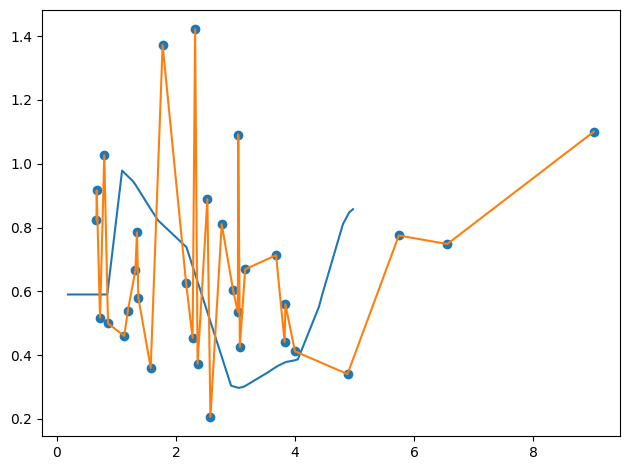

32/32 [==============================] - 0s 12ms/step - d_loss: 0.6433 - g_loss: 0.6035


In [ ]:
gan = GAN_1D(gen, dis, 5)

gan.compile()

x = np.random.random((1000, 32))
y = np.random.random((1000, 1))

gan.fit(x, y, epochs=100, callbacks = [CustomCallback()])